In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

## Introduction

In this notebook, we will estimate the parameters of the simple diffusion model from a simulated response times (RTs) data set using Stan's implementation of Hamiltonian Monte Carlo (HMC). But, wait! Since we are simulating the data (i.e., solving the forward problem), don't we already know the parameters with absolute certainty? Indeed, in this case we do, and this little exercise will introduce a crucial principle of all computational modeling: **Parametric models are nothing but assumptions about the unknown data-generating process**, so, in a way, the inverse problem (i.e., going from data to parameters) presupposes the forward problem. 

Thus, even when we are estimating the parameters from an actually observed data set, we are assuming that the parametric model is the accurate description of the system that generated the data. In other words, we hope that our model is *well-specified*. Simulation studies enable science *in silico*, that is, before collecting any data, we can already play oracles and test what we can learn from the data by successively solving the forward and the inverse problem.

## Diffusion Model Simulator

In [36]:
def simulate_diffusion(v, a, beta, tau, dt=1e-3, scale=1.0, max_time=10., rng=None):
    """
    Simulates one realization of the diffusion process given
    a set of parameters and a step size `dt`.

    Parameters:
    -----------
    v        : float
        The drift rate (rate of information uptake)
    a        : float
        The boundary separation (decision threshold).
    beta     : float in [0, 1]
        Relative starting point (prior option preferences)
    tau      : float
        Non-decision time (additive constant)
    dt       : float, optional (default: 1e-3 = 0.001)
        The step size for the Euler algorithm.
    scale    : float, optional (default: 1.0)
        The scale (sqrt(var)) of the Wiener process. Not considered
        a parameter and typically fixed to either 1.0 or 0.1.
    max_time : float, optional (default: .10)
        The maximum number of seconds before forced termination.
    rng      : np.random.Generator or None, optional (default: None)
        A random number generator with locally set seed or None
        If None provided, a new generator will be spawned within the function.
        
    Returns:
    --------
    (x, c) - a tuple of response time (y - float) and a 
        binary decision (c - int) 
    """

    # Inits (process starts at relative starting point)
    y = beta * a
    num_steps = tau
    const = scale*np.sqrt(dt)
    if rng is None:
        rng = np.random.default_rng()

    # Loop through process and check boundary conditions
    while (y <= a and y >= 0) and num_steps <= max_time:

        # Perform diffusion equation
        z = rng.normal()
        y += v*dt + const*z

        # Increment step counter
        num_steps += dt

    if y >= a:
        c = 1.
    else:
        c = 0.
    return (round(num_steps, 4), c)

## Helper Functions

In [37]:
def simulate_diffusion_n(num_sims, v, a, beta, tau, dt=1e-3, scale=1.0, max_time=10., rng=None):
    """Add a nice docstring."""

    # Inits
    data = np.zeros((num_sims, 2))
    if rng is None:
        rng = np.random.default_rng()
    
    # Create data set
    for n in range(num_sims):
        data[n, :] = simulate_diffusion(v, a, beta, tau, dt, scale, max_time, rng)
    return data


def visualize_data(data, figsize=(10, 5)):
    """Helper function to visualize a simple response time data set."""

    f, axarr = plt.subplots(1, 2, figsize=figsize)
    
    # Histogram of response times
    sns.histplot(
        data[:, 0][data[:, 1] == 1], ax=axarr[0], color='#AA0000', alpha=0.8, lw=2, label=f'Response 1')
    sns.histplot(
        data[:, 0][data[:, 1] == 0], ax=axarr[0], color='#0000AA', alpha=0.8, lw=2, label=f'Response 0')

    # Barplot of categorical responses
    response, frequency = np.unique(data[:, 1], return_counts=True)
    sns.barplot(x=response.astype(np.int32), y=frequency, ax=axarr[1], alpha=0.8, color='#00AA00')

    # Labels and embelishments
    axarr[0].set_xlabel('Response time (s)', fontsize=16)
    axarr[0].legend(fontsize=16)
    axarr[0].set_ylabel('Count', fontsize=16)
    axarr[1].set_xlabel('Response', fontsize=16)
    axarr[1].set_ylabel('Frequency', fontsize=16)
    for ax in axarr:
        sns.despine(ax=ax)
        ax.grid(alpha=0.1, color='black')

    f.suptitle('Data Summary', fontsize=18)

    f.tight_layout()

In [38]:
# Ensure reproducibility
RNG = np.random.default_rng(2024)

# Set ground-truth parameters
parameters = {
    'v': 1.6,
    'a': 0.8,
    'beta': 0.6,
    'tau': 0.4
}

# Set additional simulation settings
control = {
    'num_sims': 120,
    'rng': RNG,
    'dt': 1e-3
}

# Create data with above configuration
data = simulate_diffusion_n(**{**control, **parameters})

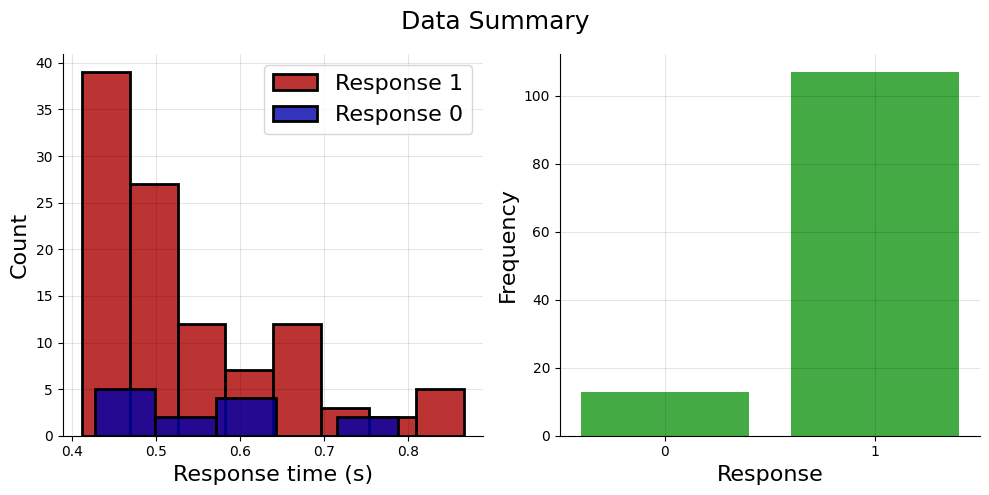

In [39]:
visualize_data(data)

## Bayesian Parameter Estimation

Now, we will write a Stan program to sample from the posterior of the diffusion model parameters given the observed data.

### Stan Program

In [91]:
program_code = """

data {
    int<lower=1> N;
    array[N] real<lower=0> y;
    array[N] int<lower=0, upper=1> c;
}

parameters {
    real<lower=0> v;
    real<lower=0> a;
    real<lower=0, upper=1> beta;
    real<lower=0> tau;
}

model {
    // Priors
    v ~ gamma(3, 1);
    a ~ gamma(3, 1);
    beta ~ beta(2, 2);
    tau ~ gamma(2, 1);

    // Likelihood
    for (n in 1:N) {
        // Your code here
    }
}
"""

### Visualizing the Prior Distributions

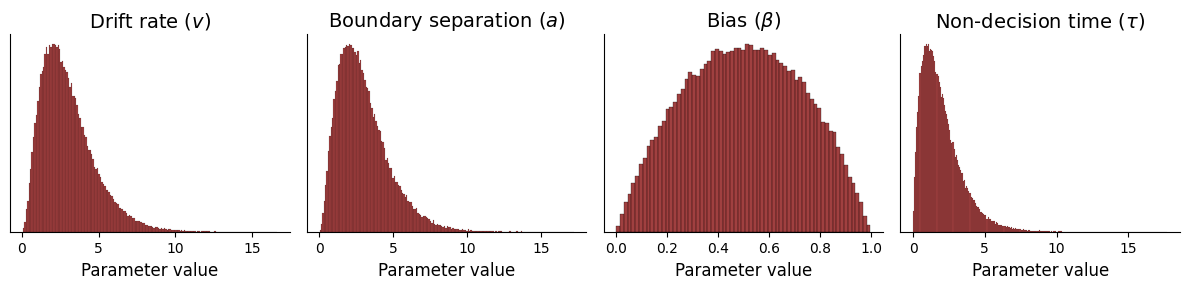

In [92]:
### Visualizing our priors the lazy way

f, axarr = plt.subplots(1, 4, figsize=(12, 3))
param_names = [r'Drift rate ($v$)', r'Boundary separation ($a$)', r'Bias ($\beta$)', r'Non-decision time ($\tau$)']
sns.histplot(np.random.gamma(3, 1, size=100000), color='maroon', ax=axarr[0])
sns.histplot(np.random.gamma(3, 1, size=100000), color='maroon', ax=axarr[1])
sns.histplot(np.random.beta(2, 2, size=100000), color='maroon', ax=axarr[2])
sns.histplot(np.random.gamma(2, 1, size=100000), color='maroon', ax=axarr[3])

for ax, p in zip(axarr, param_names):
    ax.set_title(p, fontsize=14)
    ax.set_xlabel('Parameter value', fontsize=12)
    ax.set_yticks([])
    ax.set_ylabel('')
    sns.despine(ax=ax)

f.tight_layout()

### Compilation and Sampling

In [93]:
# Prepare data in Stan friendly format
data_dict = {
    'y': data[:, 0], 
    'c': data[:, 1].astype(int),
    'N': data.shape[0]
}

# Compile model
model = stan.build(program_code, data=data_dict)

Building...



Building: 14.2s, done.

In [94]:
# Posterior inference using MCMC
fit = model.sample(num_chains=4, num_warmup=1000, num_samples=2500)

Sampling:   0%
Sampling:   0% (1/14000)
Sampling:   0% (2/14000)
Sampling:   0% (3/14000)
Sampling:   0% (4/14000)
Sampling:   1% (103/14000)
Sampling:   1% (202/14000)
Sampling:   2% (301/14000)
Sampling:   4% (500/14000)
Sampling:   5% (700/14000)
Sampling:   7% (1000/14000)
Sampling:   9% (1300/14000)
Sampling:  11% (1500/14000)
Sampling:  14% (1900/14000)
Sampling:  16% (2200/14000)
Sampling:  18% (2500/14000)
Sampling:  20% (2800/14000)
Sampling:  40% (5600/14000)
Sampling:  60% (8400/14000)
Sampling:  80% (11200/14000)
Sampling: 100% (14000/14000)
Sampling: 100% (14000/14000), done.
Messages received during sampling:
  Gradient evaluation took 0.000829 seconds
  1000 transitions using 10 leapfrog steps per transition would take 8.29 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/tmp/h

In [98]:
# Extract samples
df = fit.to_frame()

In [100]:
# Posterior summary statistics
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,2.049,0.316,1.437,2.634,0.005,0.003,4686.0,4602.0,1.0
a,0.903,0.051,0.810,0.999,0.001,0.000,5388.0,5716.0,1.0
beta,0.552,0.040,0.480,0.627,0.001,0.000,4465.0,5824.0,1.0
tau,0.391,0.006,0.380,0.401,0.000,0.000,4485.0,4877.0,1.0


/home/radevs/anaconda3/envs/cognitive/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/traceplot.py:433: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for chain_id in range(data.dims["chain"])


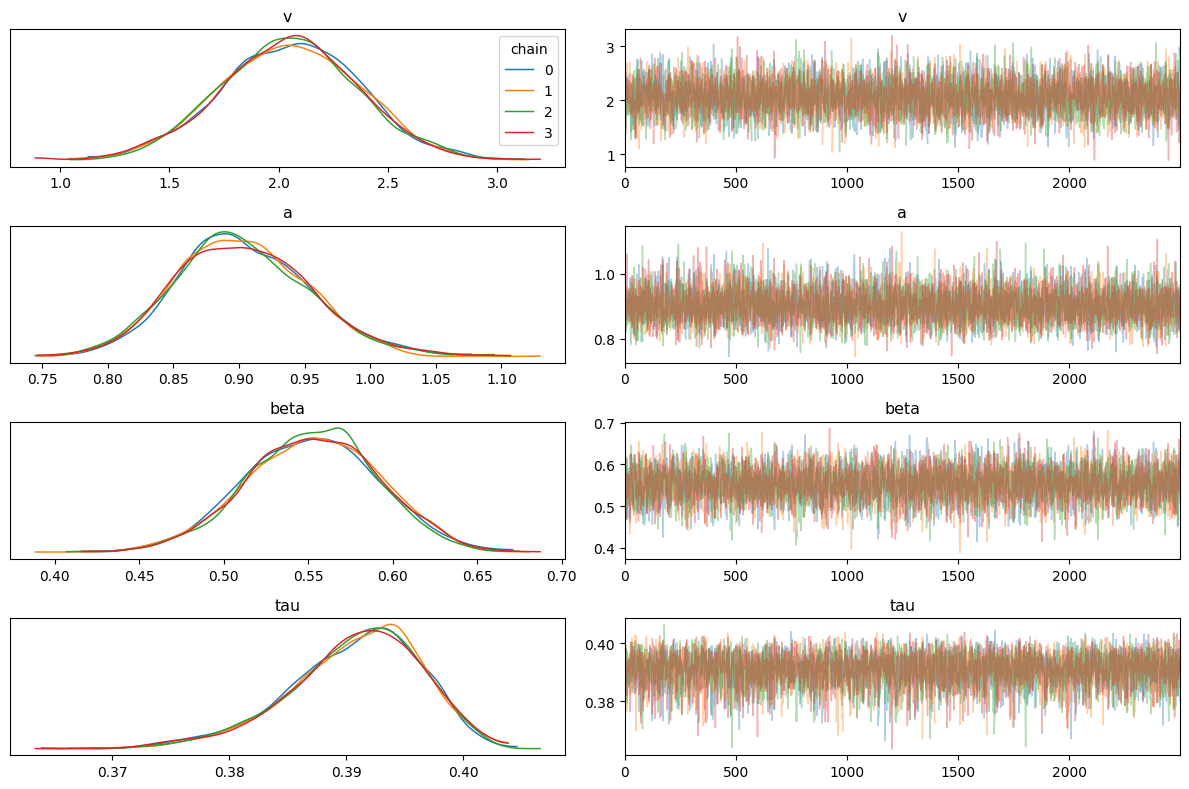

In [104]:
# Traceplots 
f = az.plot_trace(fit, compact=False, legend=True)
plt.tight_layout()

In [105]:
# Inspect diagnostics and create custom functions